In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import genfromtxt
from scipy.stats import gamma, uniform

In [76]:
disasters = genfromtxt('disasters.csv', delimiter = ',')

def init_mcmc(N, num_breakpoints, psi, rho, print_debug = False):

    
    #log-probability of t
    prior_t_log = lambda t: np.sum(np.log(np.diff(t))) if np.all(t[:-1] <= t[1:]) else 0
    
    #The log-probability of tau given parameters
    f_tau_log = lambda t, lambdas, nt: -np.sum(np.diff(t)*lambdas) + np.sum(nt*np.log(lambdas))
    
    #Initialize arrays
    breakpoints = np.arange(1658,1981, (1980-1658)/(num_breakpoints+1))
    tau = disasters
    
    #Initial burn in attempts if needed
    burn_in = 0
    M = N + burn_in

    #Arrays to save values of lambda and theta
    lambdas = np.zeros((M, num_breakpoints + 1))
    thetas = np.zeros((M, num_breakpoints + 1))
    
    #Main loop
    for index in range(M):
        
        #Theta is independent, sample one theta for each interval
        thetas[index] = gamma(2, psi).rvs(num_breakpoints + 1)
        for section in range(num_breakpoints + 1):
            lambdas[index, section] = gamma(2, thetas[index, section]).rvs(1)
            
        if print_debug:
            print(f'Iter: {index}')
            print(f' Theta: {thetas[index]}')
            print(f' Lambda: {lambdas[index]}')
            
        #Random walk proposal for breakpoints
        for t in np.arange(num_breakpoints) + 1:
            
            ti = breakpoints[t]
            R = rho*(breakpoints[t+1] - breakpoints[t-1])
            epsilon = np.random.uniform(-R, R)
            ti_proposal = ti+epsilon
            
            #Proposed array of breakpoints
            breakpoints_propose = np.copy(breakpoints)
            breakpoints_propose[t] = ti_proposal

            # If breakpoints are not sorted the probability is zero
            if(np.all(breakpoints_propose[:-1] <= breakpoints_propose[1:])):
            
                #Num incidents per interval
                nt_current = np.histogram(tau, bins = breakpoints)[0].astype('int32')
                nt_propose = np.histogram(tau, bins = breakpoints_propose)[0].astype('int32')
                    
                
                
                #log-Probability of proposed breakpoints
                p_propose = np.exp(prior_t_log(breakpoints_propose) + f_tau_log(breakpoints_propose, lambdas[index], nt_propose))
                
                #log-Probability of current breakpoints
                p_current = np.exp(prior_t_log(breakpoints) + f_tau_log(breakpoints, lambdas[index], nt_current))
                
                #Probability of accept
                p_accept = np.minimum(1, p_propose/p_current)
                
            else:
                p_accept = 0
                         
            accept = np.random.uniform(0,1) < p_accept
            
            if print_debug:
                print(f'Breakpoint {t}')
                print(f' Current breakpoints: {breakpoints}')
                print(f' Proposed breakpoints: {breakpoints_propose}')
                print(f'nt current: {nt_current}')
                print(f'nt propose: {nt_propose}')
                print(f'p current: {p_current}')
                print(f'p propose: {p_propose}')
                print(f' P(accept) = {p_accept}')
                print(f' Accept: {accept}')

            if accept:
                breakpoints = np.copy(breakpoints_propose)

    return breakpoints
    

In [103]:
n = 100
d = 5
breakpoints_all = np.zeros((n, d+2))
for i in range(n):
    breakpoints_all[i] = init_mcmc(N = 10**2, num_breakpoints = d, psi = 0.001, rho = 0.5, print_debug = False)

<ipython-input-76-4bbd85c26dc3>:65: RuntimeWarning: divide by zero encountered in double_scalars
  p_accept = np.minimum(1, p_propose/p_current)
<ipython-input-76-4bbd85c26dc3>:65: RuntimeWarning: invalid value encountered in double_scalars
  p_accept = np.minimum(1, p_propose/p_current)


In [105]:
mean = np.mean(breakpoints_all, axis = 0)
var = np.var(breakpoints_all, axis = 0)
interval = 1.96*np.sqrt(var/n)
print(mean)
print(interval)
np.diff(mean)

[1658.         1721.48343786 1777.05957874 1830.23117655 1877.54726607
 1929.5287335  1980.        ]
[0.00000000e+00 1.02665720e+01 1.12055462e+01 1.08715109e+01
 1.03842855e+01 7.83913013e+00 4.45652404e-14]


array([63.48343786, 55.57614088, 53.17159781, 47.31608952, 51.98146743,
       50.4712665 ])

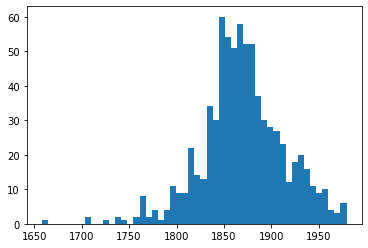

In [100]:
_ = plt.hist(disasters, bins = 50)

0.1353352832366127

In [49]:
np.sum(nt*np.log(lambdas))

793.0260852492054

In [50]:
nt

array([ 79, 672])

In [51]:
np.log(lambdas)

array([0.69314718, 1.09861229])